In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from diffusers import DDPMScheduler, UNet2DModel



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff121ba6300>>
Traceback (most recent call last):
  File "/home/xiehuachong/miniconda3/envs/mytorch/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/home/xiehuachong/miniconda3/envs/mytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device_with_max_free_memory():
    if not torch.cuda.is_available():
        print("CUDA is not available. Using CPU.")
        return torch.device("cpu")
    
    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {num_devices}")
    
    max_free_memory = 0
    best_device = None
    
    for i in range(num_devices):
        props = torch.cuda.get_device_properties(i)
        free_memory, total_memory = torch.cuda.mem_get_info(i)
        free_memory_mb = free_memory / (1024 ** 3)  # 转换为 GB
        
        print(f"Device {i}: {props.name}, Free memory: {free_memory_mb:.2f} GB")
        
        if free_memory > max_free_memory:
            max_free_memory = free_memory
            best_device = i
    
    print(f"Selected Device: CUDA:{best_device} with {max_free_memory / (1024 ** 2):.2f} MB free memory")
    return torch.device(f"cuda:{best_device}")

# 获取最佳设备
device = get_device_with_max_free_memory()
# device = 'cuda:8'
print(f'Using device: {device}')

Number of CUDA devices available: 9
Device 0: NVIDIA GeForce RTX 4090, Free memory: 7.95 GB
Device 1: NVIDIA GeForce RTX 4090, Free memory: 7.95 GB
Device 2: NVIDIA GeForce RTX 4090, Free memory: 7.95 GB
Device 3: NVIDIA A800 80GB PCIe, Free memory: 1.60 GB
Device 4: NVIDIA A800 80GB PCIe, Free memory: 1.60 GB
Device 5: NVIDIA A800 80GB PCIe, Free memory: 1.60 GB
Device 6: NVIDIA A800 80GB PCIe, Free memory: 51.47 GB
Device 7: NVIDIA RTX A6000, Free memory: 47.27 GB
Device 8: NVIDIA RTX A6000, Free memory: 47.27 GB
Selected Device: CUDA:6 with 52700.56 MB free memory
Using device: cuda:6


# 数据

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([8, 9, 2, 0, 0, 7, 1, 0, 9, 8, 6, 1, 3, 3, 7, 0, 7, 9, 7, 6, 9, 5, 9, 4,
        8, 4, 3, 0, 0, 6, 2, 0, 1, 6, 4, 1, 3, 5, 7, 1, 8, 6, 2, 4, 4, 3, 4, 9,
        8, 2, 6, 5, 7, 3, 0, 0, 4, 2, 1, 4, 3, 4, 4, 0])


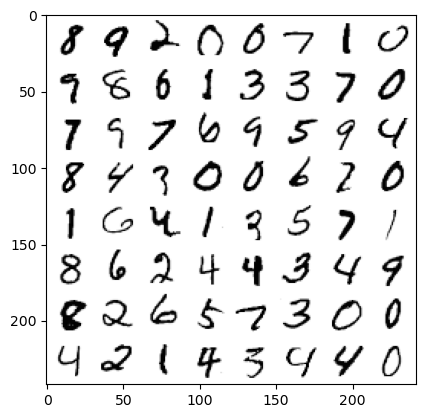

In [3]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

# 模型

In [4]:
# 噪声预测网络
model = UNet2DModel(
    sample_size=28,           # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=( 
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
print(f"模型参数量：{sum([p.numel() for p in model.parameters()]):2e}")
# print(model) 

模型参数量：1.707009e+06


In [5]:
def corrupt(x, noise_amount):
    noise = torch.rand_like(x)
    # 每个样本的 amount 值应用到对应的整张图像，而不是单个像素点
    noise_amount = noise_amount.view(-1,1,1,1) # 在广播时，变成的维度
    noise_x = (1-noise_amount) * x + noise_amount * noise
    return noise_x


# 训练

In [6]:
# 超参数定义
batch_size = 256
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
max_epoch = 5

model = model
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

loss_fn = nn.MSELoss()
losses = []

In [7]:
# 训练过程
import time
for epoch in range(max_epoch):
    stime = time.time()
    for x, y in train_dataloader:

        x = x.to(device) 
        noise_amount = torch.rand(x.shape[0]).to(device) 
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # 正向传播
        pred = model(noisy_x, 0).sample #<<< Using timestep 0 always, adding .sample

        # 计算loss，反向传播，更新参数
        loss = loss_fn(pred, x) 
        loss.backward()
        opt.step()
        opt.zero_grad()

        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    timecost = time.time() - stime
    print(f'{timecost:2f}: [{epoch+1}/{max_epoch}]. Average loss for this epoch: {avg_loss:05f}')

24.466136: [1/5]. Average loss for this epoch: 0.021340
22.815434: [2/5]. Average loss for this epoch: 0.013970
23.438821: [3/5]. Average loss for this epoch: 0.012324
24.339514: [4/5]. Average loss for this epoch: 0.011446
24.303109: [5/5]. Average loss for this epoch: 0.011003


# 测试

tensor([8, 8, 6, 9, 9, 2, 3, 7, 3, 6, 4])


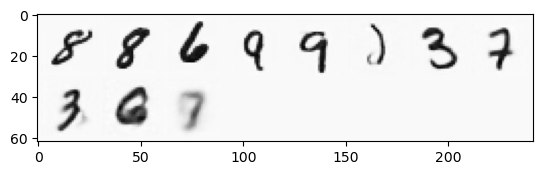

In [8]:
train_dataloader = DataLoader(dataset, batch_size=11, shuffle=True)
x, y = next(iter(train_dataloader))
noise_amount = torch.arange(0,1.1,0.1)
x = corrupt(x,noise_amount)

x = x.to(model.device) 

with torch.no_grad():
    pred = model(x,0)

pred = pred.sample.to('cpu')
plt.imshow(torchvision.utils.make_grid(pred)[0], cmap='Greys');
print(y)

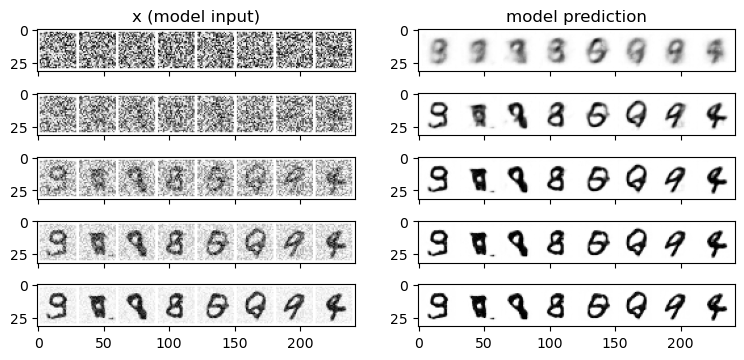

In [10]:
n_steps = 5
x = torch.rand(8,1,28,28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = model(x, 0)
        pred = pred.sample
    pred_output_history.append(pred.detach().cpu())

    process_factor = (i+1)/n_steps 
    process_factor = 1/(n_steps-i)
    x = process_factor * pred + (1-process_factor) * x
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')